In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate

from sklearn.metrics import log_loss, roc_auc_score, roc_curve, make_scorer, brier_score_loss

Define Mcfadden's pseduo r-squared

In [ ]:
def mcfadden_r2(y, y_pred):
    ll = log_loss(y, y_pred)
    ll_null = log_loss(y, np.full(len(y), y.mean()))
    return 1 - (ll/ll_null)
pseudo_r2_scorer = make_scorer(mcfadden_r2, needs_proba=True, greater_is_better=True)

In [ ]:
scoring = {'roc_aug': 'roc_auc', 'mcfaddens_r2': pseudo_r2_scorer}

Load the data

In [ ]:
cwd = os.getcwd()
df = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))

Drop first the columns without any information useful such as id's and names. Also drop columns for random forest. RF does not deal well with columns with missing data (the ones that come from StatsBomb only).
Split data in penalty and non-penalty shots and subset dataset for random forest.

In [5]:
df.drop(['match_id', 'statsbomb_id', 'statsbomb_team_id', 'player_id_statsbomb', 'competition_gender', 'team_name',
         'player_id', 'firstName', 'middleName', 'lastName', 'Name', 'dataset', 'wyscout_id', 'wyscout_team_id', 'team_id',
         'player_id_wyscout','competition_name','minute','shot_zone','match_week','pass_end_y',
         'goalkeeper_x', 'goalkeeper_y', 'carry_length', 'shot_one_on_one', 'shot_open_goal','under_pressure', 'area_shot', 
         'area_goal', 'n_angle', 'smart_pass','pass_end_x'], axis=1, inplace=True)
mask_penalty = (df.shot_type_name=='penalty')
df_penalty = df[mask_penalty].copy()
df_penalty.drop(['x','y','visible_angle','middle_angle','distance_to_goal','distance_visible_angle','log_distance_to_goal',
                 'assist_type', 'pass_switch', 'pass_cross', 'pass_cut_back','counter_attack', 'pass_height_name',
                 'pass_technique_name', 'shot_zone_number','shot_zone_player_number','fast_break', 'strong_foot',
                 'body_part_name','shot_type_name'], axis=1, inplace=True)
df_non_penalty = df[~mask_penalty].copy()

Split dataset for random forest into passes / other assists. They have diferent columns of information.

In [6]:
def split(X):
    mask = X.assist_type == 'pass'
    X_pass = X[mask].drop('assist_type', axis=1).copy()
    X_other = X[~mask].dropna(axis=1, how='all').copy()
    return X_pass, X_other

In [7]:
df_np_pass,  df_np_other = split(df_non_penalty)

Generate dummy columns for categorical variables. After that split the three datasets into train and test datasets.

In [8]:
df_np_pass = pd.get_dummies(df_np_pass, columns=['competition_type','competition_part','H_A_column','match_moment',
                                                 'shot_type_name', 'body_part_name','pass_technique_name','pass_height_name'])
df_np_other = pd.get_dummies(df_np_other, columns=['competition_type','competition_part','H_A_column','match_moment',
                                                   'assist_type','shot_type_name', 'body_part_name'])
df_p = pd.get_dummies(df_penalty, columns=['competition_type','competition_part','H_A_column','match_moment'])
y_np_pass = df_np_pass['goal']
x_np_pass = df_np_pass.drop(['goal'], axis=1)
x_npp_train, x_npp_test, y_npp_train, y_npp_test = train_test_split(x_np_pass, y_np_pass, train_size=0.8, random_state=42,
                                                                    stratify=y_np_pass)
y_np_other = df_np_other['goal']
x_np_other = df_np_other.drop(['goal'], axis=1)
x_npo_train, x_npo_test, y_npo_train, y_npo_test = train_test_split(x_np_other, y_np_other, train_size=0.8, random_state=42,
                                                                    stratify=y_np_other)
y_p = df_p['goal']
x_p = df_p.drop(['goal'], axis=1)
x_p_train, x_p_test, y_p_train, y_p_test = train_test_split(x_p, y_p, train_size=0.8, random_state=42,
                                                                    stratify=y_p)

Create two RF clf.

In [9]:
random_search_model = RandomForestClassifier(random_state=42)
grid_search_model = RandomForestClassifier(random_state=42)

In [10]:
cv_split = KFold(n_splits=5, random_state=42, shuffle=True)

In [11]:
rf_hyperparam_grid={
    "n_estimators": [100, 500],
    "max_features": ['auto', 7, 10, 15],
    "min_samples_leaf": [1, 5, 20, 100],
    "min_samples_split": [2, 10, 50, 250],
    "criterion": ["gini", "entropy"],
    "max_depth": [4, 6, 8, 10, None]
}

In [12]:
rf_random_search = RandomizedSearchCV(estimator=random_search_model, param_distributions=rf_hyperparam_grid, n_iter=200, 
                                    scoring="neg_log_loss", return_train_score=True, cv=cv_split, verbose=10,
                                    n_jobs=-1, random_state=42)

In [13]:
tuned_random_model_npp = rf_random_search.fit(x_npp_train, y_npp_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8

In [14]:
tuned_random_model_npp.best_params_

{'n_estimators': 500,
 'min_samples_split': 50,
 'min_samples_leaf': 20,
 'max_features': 7,
 'max_depth': 10,
 'criterion': 'entropy'}

In [ ]:
random_y_hat_npp = tuned_random_model_npp.predict_proba(x_npp_test)
print("The log loss of the model with Random Search is: " + str(log_loss(y_npp_test, random_y_hat_npp)))
print("The ROC AUC score of the model with Random Search is: " +str(roc_auc_score(y_npp_test, random_y_hat_npp[:,1])))

- The log loss of the model with Random Search is: 0.2938047267611026
- The ROC AUC score of the model with Random Search is: 0.7763513660967295

In [ ]:
tuned_random_model_npo = rf_random_search.fit(x_npo_train, y_npo_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 23

In [ ]:
tuned_random_model_npo.best_params_

In [ ]:
random_y_hat_npo = tuned_random_model_npo.predict_proba(x_npo_test)
print("The log loss of the model with Random Search is: " + str(log_loss(y_npo_test, random_y_hat_npo)))
print("The ROC AUC score of the model with Random Search is: " +str(roc_auc_score(y_npo_test, random_y_hat_npo[:,1])))

In [ ]:
tuned_random_model_p = rf_random_search.fit(x_p_train, y_p_train)

In [17]:
tuned_random_model_p.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 100,
 'max_features': 'auto',
 'max_depth': None,
 'criterion': 'gini'}

In [ ]:
random_y_hat_p = tuned_random_model_p.predict_proba(x_p_test)
print("The log loss of the model with Random Search is: " + str(log_loss(y_p_test, random_y_hat_p)))
print("The ROC AUC score of the model with Random Search is: " +str(roc_auc_score(y_p_test, random_y_hat_p[:,1])))

The log loss of the model with Random Search is: 0.5723009879746499
The ROC AUC score of the model with Random Search is: 0.5310712924132673


In [ ]:
y_pred_random = np.concatenate([random_y_hat_npp, random_y_hat_npo])
y_true_test = np.concatenate([y_npp_test, y_npo_test])
fraction_of_positives_random, mean_predicted_value_random = calibration_curve(y_true_test, y_pred_random[:, 1], n_bins=10)

In [ ]:
plt.style.use('dark_background')
fig = plt.figure(constrained_layout=True, figsize=(10, 15))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=(2/3, 1/3))
ax1 = fig.add_subplot(gs[0])
ax1.plot(mean_predicted_value_random, fraction_of_positives_random, "-o", color='#dbdf4a', label='Logistic regression')
ax1.plot([0, 1], [0, 1], "--", color='#e7aeca', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=15)
ax1.set_ylabel('Fraction of positives', fontsize=15)
ax1.set_title('Calibration curve', fontsize=20, pad=10)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)
ax2 = fig.add_subplot(gs[1])
sns.distplot(y_pred_random[:, 1], color='#4fe4e4', label='Logistic regression', kde=False, ax=ax2)
ax2.set_xlabel('Predicted value', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.legend(fontsize=15)
ax2.set_title('Distribution of predictions', fontsize=20, pad=10);

In [ ]:
print("The log loss of the model with Random Search is: " + str(log_loss(y_true_test, y_pred_random)))
print("The ROC AUC score of the model with Random Search is: " +str(roc_auc_score(y_true_test, y_pred_random[:,1])))
print('Pseudo R-squared, logistic regression:', mcfadden_r2(y_true_test, y_pred_random[:,1]))
print('Brier score, logistic regression:',brier_score_loss(y_true_test, y_pred_random[:,1], pos_label=y_true_test.max()))

In [ ]:
fraction_of_positives_random_p, mean_predicted_value_random_p = calibration_curve(y_p_test, random_y_hat_p[:, 1], n_bins=10)

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(10, 15))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=(2/3, 1/3))
ax1 = fig.add_subplot(gs[0])
ax1.plot(mean_predicted_value_random_p, fraction_of_positives_random_p, "-o", color='#dbdf4a', label='Logistic regression')
ax1.plot([0, 1], [0, 1], "--", color='#e7aeca', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=15)
ax1.set_ylabel('Fraction of positives', fontsize=15)
ax1.set_title('Calibration curve', fontsize=20, pad=10)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)
ax2 = fig.add_subplot(gs[1])
sns.distplot(random_y_hat_p[:, 1], color='#4fe4e4', label='Logistic regression', kde=False, ax=ax2)
ax2.set_xlabel('Predicted value', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.legend(fontsize=15)
ax2.set_title('Distribution of predictions', fontsize=20, pad=10);
fig.savefig(os.path.join(cwd, 'figures', '22_calibration_curve.png'), bbox_inches = 'tight', pad_inches = 0.2)

In [ ]:
print("The log loss of the model with Random Search is: " + str(log_loss(y_p_test, random_y_hat_p)))
print("The ROC AUC score of the model with Random Search is: " +str(roc_auc_score(y_p_test, random_y_hat_p[:,1])))
print('Pseudo R-squared, logistic regression:', mcfadden_r2(y_p_test, random_y_hat_p[:,1]))
print('Brier score, logistic regression:',brier_score_loss(y_p_test, random_y_hat_p[:,1], pos_label=y_true_test_p.max()))

In [80]:
rf_grid_search=GridSearchCV(estimator=grid_search_model, param_grid=rf_hyperparam_grid, scoring="neg_log_loss",
                            return_train_score=True, cv=cv_split, verbose=10, n_jobs=-1)

In [82]:
tuned_grid_model_npp = rf_grid_search.fit(x_npp_train, y_npp_train)

Fitting 5 folds for each of 1280 candidates, totalling 6400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

Wall time: 11min 24s


In [83]:
tuned_grid_model_npp.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 100,
 'min_samples_split': 250,
 'n_estimators': 500}

In [ ]:
grid_y_hat_npp = tuned_grid_model_npp.predict_proba(x_npp_test)
print("The log loss of the model with Random Search is: " + str(log_loss(y_np_testp, grid_y_hat_npp)))
print("The ROC AUC score of the model with Random Search is: " +str(roc_auc_score(y_npp_test, grid_y_hat_npp[:,1])))

nested_score_pass = cross_validate(tuned_grid_model_npp, X=x_npp_train, y=y_npp_train, scoring=scoring, n_jobs=-1)
print('ROC AUC for shots assisted by passes:', nested_score_pass['test_roc_aug'].mean())
print("McFadden's Pseudo R-squared for shots assisted by passes:", nested_score_pass['test_mcfaddens_r2'].mean())

In [85]:
random_fpr_npp, random_tpr_npp, random_thresholds_npp = roc_curve(y_true=y_npp_test, y_score=random_y_hat_npp[:,1])
grid_fpr_npp, grid_tpr_npp, grid_thresholds_npp = roc_curve(y_true=y_npp_test, y_score=grid_y_hat_npp[:,1])

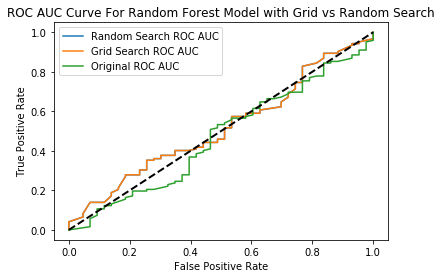

In [86]:
plt.plot(random_fpr_npp, random_tpr_npp, label='Random Search ROC AUC')
plt.plot(grid_fpr_npp, grid_tpr_npp, label='Grid Search ROC AUC')
plt.plot([0, 1], [0, 1], color = 'black', linewidth = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC AUC Curve For Random Forest Model with Grid vs Random Search')
plt.show()

In [ ]:
tuned_grid_model_npo = rf_grid_search.fit(x_npo_train, y_npo_train)

In [ ]:
tuned_grid_model_npo.best_params_

In [ ]:
grid_y_hat_npo = tuned_grid_model_npo.predict_proba(x_npo_test)
print("The log loss of the model with Random Search is: " + str(log_loss(y_npo_test, grid_y_hat_npo)))
print("The ROC AUC score of the model with Random Search is: " +str(roc_auc_score(y_npo_test, grid_y_hat_npo[:,1])))

nested_score_other = cross_validate(tuned_grid_model_npo, X=x_npo_train, y=y_npo_train, scoring=scoring, n_jobs=-1)
print('ROC AUC for shots assisted by passes:', nested_score_other['test_roc_aug'].mean())
print("McFadden's Pseudo R-squared for shots assisted by passes:", nested_score_other['test_mcfaddens_r2'].mean())

In [ ]:
y_pred_grid = np.concatenate([grid_y_hat_npp, grid_y_hat_npo])
y_true_test = np.concatenate([y_npp_test, y_npo_test])
fraction_of_positives_grid, mean_predicted_value_grid = calibration_curve(y_true_test, y_pred_grid[:, 1], n_bins=10)

In [ ]:
plt.style.use('dark_background')
fig = plt.figure(constrained_layout=True, figsize=(10, 15))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=(2/3, 1/3))
ax1 = fig.add_subplot(gs[0])
ax1.plot(mean_predicted_value_grid, fraction_of_positives_grid, "-o", color='#dbdf4a', label='Logistic regression')
ax1.plot([0, 1], [0, 1], "--", color='#e7aeca', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=15)
ax1.set_ylabel('Fraction of positives', fontsize=15)
ax1.set_title('Calibration curve', fontsize=20, pad=10)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)
ax2 = fig.add_subplot(gs[1])
sns.distplot(y_pred_grid[:, 1], color='#4fe4e4', label='Logistic regression', kde=False, ax=ax2)
ax2.set_xlabel('Predicted value', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.legend(fontsize=15)
ax2.set_title('Distribution of predictions', fontsize=20, pad=10);

In [ ]:
print("The log loss of the model with Random Search is: " + str(log_loss(y_true_test, y_pred_grid)))
print("The ROC AUC score of the model with Random Search is: " +str(roc_auc_score(y_true_test, y_pred_grid[:,1])))
print('Pseudo R-squared, logistic regression:', mcfadden_r2(y_true_test, y_pred_grid[:,1]))
print('Brier score, logistic regression:',brier_score_loss(y_true_test, y_pred_grid[:,1], pos_label=y_true_test.max()))

In [ ]:
fraction_of_positives_grid_p, mean_predicted_value_grid_p = calibration_curve(y_p_test, grid_y_hat_p[:, 1], n_bins=10)

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(10, 15))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=(2/3, 1/3))
ax1 = fig.add_subplot(gs[0])
ax1.plot(mean_predicted_value_grid_p, fraction_of_positives_grid_p, "-o", color='#dbdf4a', label='Logistic regression')
ax1.plot([0, 1], [0, 1], "--", color='#e7aeca', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=15)
ax1.set_ylabel('Fraction of positives', fontsize=15)
ax1.set_title('Calibration curve', fontsize=20, pad=10)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)
ax2 = fig.add_subplot(gs[1])
sns.distplot(grid_y_hat_p[:, 1], color='#4fe4e4', label='Logistic regression', kde=False, ax=ax2)
ax2.set_xlabel('Predicted value', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.legend(fontsize=15)
ax2.set_title('Distribution of predictions', fontsize=20, pad=10);
fig.savefig(os.path.join(cwd, 'figures', '22_calibration_curve.png'), bbox_inches = 'tight', pad_inches = 0.2)

In [ ]:
print("The log loss of the model with Random Search is: " + str(log_loss(y_p_test, grid_y_hat_p)))
print("The ROC AUC score of the model with Random Search is: " +str(roc_auc_score(y_p_test, grid_y_hat_p[:,1])))
print('Pseudo R-squared, logistic regression:', mcfadden_r2(y_p_test, grid_y_hat_p[:,1]))
print('Brier score, logistic regression:',brier_score_loss(y_p_test, grid_y_hat_p[:,1], pos_label=y_true_test_p.max()))

In [ ]:
random_fpr_npo, random_tpr_npo, random_thresholds_npo = roc_curve(y_true=y_npo_test, y_score=random_y_hat_npo[:,1])
grid_fpr_npo, grid_tpr_npo, grid_thresholds_npo = roc_curve(y_true=y_npo_test, y_score=grid_y_hat_npo[:,1])

In [ ]:
plt.plot(random_fpr_npo, random_tpr_npo, label='Random Search ROC AUC')
plt.plot(grid_fpr_npo, grid_tpr_npo, label='Grid Search ROC AUC')
plt.plot([0, 1], [0, 1], color = 'black', linewidth = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC AUC Curve For Random Forest Model with Grid vs Random Search')
plt.show()

In [ ]:
tuned_grid_model_p = rf_grid_search.fit(x_p_train, y_p_train)

In [ ]:
tuned_grid_model_p.best_params_

In [ ]:
grid_y_hat_p = tuned_grid_model_p.predict_proba(x_p_test)
print("The log loss of the model with Random Search is: " + str(log_loss(y_p_test, grid_y_hat_p)))
print("The ROC AUC score of the model with Random Search is: " +str(roc_auc_score(y_p_test, grid_y_hat_p[:,1])))

nested_score_penalty = cross_validate(tuned_grid_model_p, X=x_p_train, y=y_p_train, scoring=scoring, n_jobs=-1)
print('ROC AUC for shots assisted by passes:', nested_score_penalty['test_roc_aug'].mean())
print("McFadden's Pseudo R-squared for shots assisted by passes:", nested_score_penalty['test_mcfaddens_r2'].mean())

In [ ]:
grid_y_hat_p = tuned_grid_model.predict_proba(x_p_test)
random_fpr_p, random_tpr_p, random_thresholds_p = roc_curve(y_true=y_p_test, y_score=random_y_hat_p[:,1])
grid_fpr_p, grid_tpr_p, grid_thresholds_p = roc_curve(y_true=y_p_test, y_score=grid_y_hat_p[:,1])

In [ ]:
plt.plot(random_fpr_p, random_tpr_p, label='Random Search ROC AUC')
plt.plot(grid_fpr_p, grid_tpr_p, label='Grid Search ROC AUC')
plt.plot([0, 1], [0, 1], color = 'black', linewidth = 2, linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC AUC Curve For Random Forest Model with Grid vs Random Search')
plt.show()

In [87]:
better_rf_hyperparam_grid_npp={
    "n_estimators": [500],
    "max_features": [5, 6, 7, 8, 9],
    "min_samples_leaf": [1, 2, 5, 10, 15, 20],
    "min_samples_split": [100, 200, 250, 300, 400],
    "criterion": ["gini"],
    "max_depth": [5, 6, 7, 8, 9]
}

In [ ]:
better_rf_hyperparam_grid_npo={
    "n_estimators": [500],
    "max_features": [5, 6, 7, 8, 9],
    "min_samples_leaf": [1, 2, 5, 10, 15, 20],
    "min_samples_split": [100, 200, 250, 300, 400],
    "criterion": ["gini"],
    "max_depth": [5, 6, 7, 8, 9]
}

In [ ]:
better_rf_hyperparam_grid_p={
    "n_estimators": [500],
    "max_features": [5, 6, 7, 8, 9],
    "min_samples_leaf": [1, 2, 5, 10, 15, 20],
    "min_samples_split": [100, 200, 250, 300, 400],
    "criterion": ["gini"],
    "max_depth": [5, 6, 7, 8, 9]
}

In [88]:
better_random_search_model = RandomForestClassifier(random_state=42)

In [ ]:
better_rf_random_search_npp = RandomizedSearchCV(estimator=better_random_search_model,
                                                 param_distributions=better_rf_hyperparam_grid_npo, n_iter=250,
                                                 scoring="neg_log_loss", return_train_score=True, cv=cv_split, verbose=10,
                                                 n_jobs=-1, random_state=42)

In [ ]:
better_tuned_random_model_npp = better_rf_random_search_npo.fit(x_npp_train, y_npp_train)

In [91]:
better_tuned_random_model_npp.best_params_

{'n_estimators': 500,
 'min_samples_split': 400,
 'min_samples_leaf': 2,
 'max_features': 6,
 'max_depth': 5,
 'criterion': 'gini'}

In [102]:
y_pred_rf_pass = better_tuned_random_model_npp.predict_proba(x_npp_test)
print("The log loss of the model with Random Search for pass model is: " + str(log_loss(y_npp_test, y_pred_rf_pass)))
print("The ROC AUC score of the model with Random Search for pass model is: " +str(roc_auc_score(y_npp_test,
                                                                                                 y_pred_rf_pass[:,1])))
print('Pseudo R-squared, Random Forest for pass model is:', mcfadden_r2(y_npp_test, y_pred_rf_pass[:,1]))
print('Brier score, Random Forest for pass model is:',brier_score_loss(y_npp_test, y_pred_rf_pass[:,1],
                                                                       pos_label=y_npp_test.max()))

The log loss of the model with Random Search is: 0.5743970793730475
The ROC AUC score of the model with Random Search is: 0.5079107891727029
Pseudo R-squared, logistic regression: -0.0012327147324664445
Brier score, logistic regression: 0.19298207201794523


Wall time: 0 ns


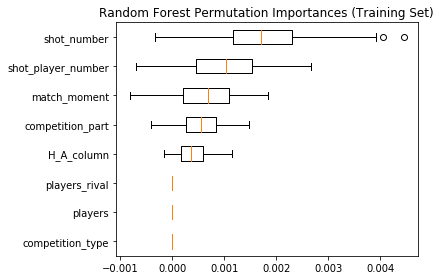

In [110]:
perm_result_npp = permutation_importance(better_tuned_random_model_npp, x_npp_train, y_npp_train, n_repeats=100,
                                         random_state=42, n_jobs=-1)
df_perm_importance_npp = pd.DataFrame({'Feature':x_npp_train.columns,
                                   'importance': perm_result_npp.importances.mean(axis=1),
                                   'std_dev': perm_result_npp.importances.std(axis=1)})
df_perm_importance_npp.sort_values('importance', ascending=False, inplace=True)
df_perm_importance_npp.reset_index(drop=True, inplace=True)
df_perm_importance_npp

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
sorted_idx = perm_result_npp.importances_mean.argsort()
bar_plot = ax.boxplot(perm_result_npp.importances[sorted_idx].T, vert=False, labels=x_npp_train.columns[sorted_idx])
ax.set_title("Random Forest Permutation Importances (Training Set)")
fig.tight_layout()
plt.show()

In [89]:
better_rf_random_search_npo = RandomizedSearchCV(estimator=better_random_search_model,
                                                 param_distributions=better_rf_hyperparam_grid_npp, n_iter=250,
                                                 scoring="neg_log_loss", return_train_score=True, cv=cv_split, verbose=10,
                                                 n_jobs=-1, random_state=42)

In [ ]:
better_tuned_random_model_npo = better_rf_random_search_npp.fit(x_npp_train, y_npo_train)

In [ ]:
better_tuned_random_model_npo.best_params_

In [ ]:
y_pred_rf_other = better_tuned_random_model_npo.predict_proba(x_npo_test)
print("The log loss of the model with Random Search for other model is: " + str(log_loss(y_npo_test, y_pred_rf_other)))
print("The ROC AUC score of the model with Random Search for other model is: " +str(roc_auc_score(y_npo_test,
                                                                                                  y_pred_rf_other[:,1])))
print('Pseudo R-squared, Random Forest for other model is:', mcfadden_r2(y_npo_test, y_pred_rf_other[:,1]))
print('Brier score, Random Forest for other model is:',brier_score_loss(y_npo_test, y_pred_rf_other[:,1],
                                                                        pos_label=y_npo_test.max()))

Wall time: 35.5 s


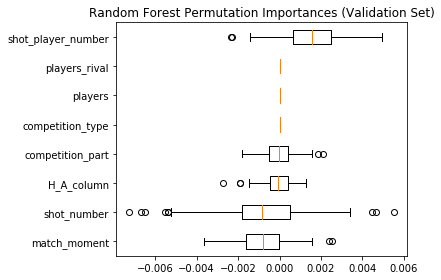

In [109]:
perm_result_npo = permutation_importance(better_tuned_random_model_npo, x_npo_train, y_npo_train, n_repeats=100,
                                         random_state=42, n_jobs=-1)
df_perm_importance_npo = pd.DataFrame({'Feature':x_npo_train.columns,
                                   'importance': perm_result_npo.importances.mean(axis=1),
                                   'std_dev': perm_result_npo.importances.std(axis=1)})
df_perm_importance_npo.sort_values('importance', ascending=False, inplace=True)
df_perm_importance_npo.reset_index(drop=True, inplace=True)
df_perm_importance_npo

In [108]:
fig, ax = plt.subplots(figsize=(16, 9))
sorted_idx = perm_result_npo.importances_mean.argsort()
bar_plot = ax.boxplot(perm_result_npo.importances[sorted_idx].T, vert=False, labels=x_npo_train.columns[sorted_idx])
ax.set_title("Random Forest Permutation Importances (Training Set)")
fig.tight_layout()
plt.show()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165 entries, 41479 to 31963
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   competition_type    165 non-null    int64  
 1   competition_part    165 non-null    int64  
 2   H_A_column          165 non-null    int64  
 3   match_moment        165 non-null    int64  
 4   shot_number         165 non-null    float64
 5   shot_player_number  165 non-null    float64
 6   players             165 non-null    float64
 7   players_rival       165 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 11.6 KB


In [ ]:
better_rf_random_search_p = RandomizedSearchCV(estimator=better_random_search_model,
                                                 param_distributions=better_rf_hyperparam_grid_p, n_iter=250,
                                                 scoring="neg_log_loss", return_train_score=True, cv=cv_split, verbose=10,
                                                 n_jobs=-1, random_state=42)

In [90]:
better_tuned_random_model_p = better_rf_random_search_p.fit(x_p_train, y_p_train)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

Wall time: 5min 3s


In [ ]:
better_tuned_random_model_p.best_params_

In [ ]:
y_pred_rf_penalty = better_tuned_random_model_p.predict_proba(x_p_test)
print("The log loss of the model with Random Search for penalty model is: " + str(log_loss(y_p_test, y_pred_rf_penalty)))
print("The ROC AUC score of the model with Random Search for penalty model is: " +str(roc_auc_score(y_p_test,
                                                                                                    y_pred_rf_penalty[:,1])))
print('Pseudo R-squared, Random Forest for penalty model is:', mcfadden_r2(y_p_test, y_pred_rf_penalty[:,1]))
print('Brier score, Random Forest for penalty model is:',brier_score_loss(y_p_test, y_pred_rf_penalty[:,1],
                                                                          pos_label=y_p_test.max()))

In [ ]:
perm_result_p = permutation_importance(better_tuned_random_model_p, x_p_train, y_p_train, n_repeats=100,
                                         random_state=42, n_jobs=-1)
df_perm_importance_p = pd.DataFrame({'Feature':x_p_train.columns,
                                   'importance': perm_result_p.importances.mean(axis=1),
                                   'std_dev': perm_result_p.importances.std(axis=1)})
df_perm_importance_p.sort_values('importance', ascending=False, inplace=True)
df_perm_importance_p.reset_index(drop=True, inplace=True)
df_perm_importance_p

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
sorted_idx = perm_result_p.importances_mean.argsort()
bar_plot = ax.boxplot(perm_result_p.importances[sorted_idx].T, vert=False, labels=x_p_train.columns[sorted_idx])
ax.set_title("Random Forest Permutation Importances (Training Set)")
fig.tight_layout()
plt.show()

In [ ]:
npp1
{'n_estimators': 500,
 'min_samples_split': 50,
 'min_samples_leaf': 20,
 'max_features': 7,
 'max_depth': 10,
 'criterion': 'entropy'}

In [ ]:
{'n_estimators': 500
 'max_features': 7,
 'min_samples_leaf': 1,
 'criterion': 'gini', 
 'min_samples_split': 250,
 'max_depth': 8,
 }

In [ ]:
"n_estimators": [500],
    "max_features": [5, 6, 7, 8, 9],
    "min_samples_leaf": [1, 2, 5, 10, 15, 20],
    "criterion": ["gini"],
    "min_samples_split": [100, 200, 250, 300, 400],
    "max_depth": [5, 6, 7, 8, 9]